# Image Classification with VGG16 and Model Evaluation

## Introduction

In this notebook, we will cover the complete process of training an image multilabel classification model to classify brain tumours in three kinds:

    - Glioma
    - Meningioma
    - Not a tumour
    - Pituitary
 
using the VGG16 architecture pre-trained weights and training two more dense layers (relU) with a softmax head. 
We will employ data augmentation techniques to improve the model's generalization and evaluate its performance on a test dataset. Additionally, we will implement and visualize the confusion matrix to better understand the model's performance across different classes.

## Contents

1. **Environment Setup**:
    - Importing the necessary libraries.
    - Setting global parameters such as batch size and image dimensions.

2. **Data Preparation**:
    - Creating data generators for the training, validation, and test datasets using `ImageDataGenerator`.
    - Applying data augmentation techniques to the training dataset.

3. **Model Definition**:
    - Using the pre-trained VGG16 architecture as the base model.
    - Adding custom layers to adapt the model to our specific classification problem.

4. **Model Training**:
    - Configuring callbacks such as `EarlyStopping` and `ModelCheckpoint` to enhance the training process.
    - Training the model using the data generators.

5. **Model Evaluation**:
    - Loading the best model saved during training.
    - Evaluating the model on the test dataset.
    - Obtaining and visualizing the confusion matrix to analyze the model's performance across different classes.

6. **Results Visualization**:
    - Visualizing the confusion matrix using `seaborn` for better interpretation of the results.

## Objectives

- Train an image classification model using transfer learning with VGG16 and added custom layers.
- Apply data augmentation techniques to improve the model's generalization capability.
- Evaluate the model's performance on a unseen dataset.
- Visualize the confusion matrix to understand the model's performance across different classes.

## Requirements

- An image dataset organized into directories for training, validation, and testing.
- Python libraries: TensorFlow, Keras, NumPy, scikit-learn, seaborn, matplotlib.

## Notebook Structure

The notebook is structured into sections that cover each of the steps mentioned above. As you progress, you will find code blocks and detailed explanations that guide you through the process of training and evaluating the model.

Let's get started!

## Import libraries

In [27]:
!pip install imutils

import numpy as np 
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools
from sklearn.metrics import confusion_matrix
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Conv2D,Input,ZeroPadding2D,BatchNormalization,Flatten,Activation,Dense,MaxPooling2D

init_notebook_mode(connected=True)
RANDOM_SEED = 123

from IPython.display import clear_output
clear_output()

## Define data loading functions

We need a function to label each image according to its containing folder and resize the images to transform them into numpy arrays. Additionally, we need to split the images into train, test, and validation datasets. To achieve this, we will define two functions: load_data for loading, resizing, and storing images, and split_train_validation for creating a validation set, with stratification to keep the classes balanced.

In [2]:
def load_data(base_dir, img_size=(224, 224)):
    def load_images_from_folder(folder_path, label_index):
        X = []
        y = []
        for file in os.listdir(folder_path):
            if not file.startswith('.'):
                img = cv2.imread(os.path.join(folder_path, file))
                if img is not None:
                    img = cv2.resize(img, img_size)
                    X.append(img)
                    y.append(label_index)
        return X, y

    X_train, y_train = [], []
    X_test, y_test = [], []
    labels = {}
    label_index = 0

    for dataset_type in ['Train', 'Test']:
        dataset_path = os.path.join(base_dir, dataset_type)
        for category in tqdm(sorted(os.listdir(dataset_path))):
            if not category.startswith('.'):
                if category not in labels:
                    labels[category] = label_index
                    label_index += 1
                category_path = os.path.join(dataset_path, category)
                if dataset_type == 'Train':
                    X, y = load_images_from_folder(category_path, labels[category])
                    X_train.extend(X)
                    y_train.extend(y)
                elif dataset_type == 'Test':
                    X, y = load_images_from_folder(category_path, labels[category])
                    X_test.extend(X)
                    y_test.extend(y)

    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)

    print(f'{len(X_train)} train images loaded from {os.path.join(base_dir, "Train")} directory.')
    print(f'{len(X_test)} test images loaded from {os.path.join(base_dir, "Test")} directory.')

    return (X_train, y_train), (X_test, y_test), labels


base_dir = "/kaggle/input/brain-tumour-classification/BrainTumor_1/"
(X_train, y_train), (X_test, y_test), labels = load_data(base_dir)

100%|██████████| 4/4 [00:13<00:00,  3.28s/it]


22848 train images loaded from /kaggle/input/brain-tumour-classification/BrainTumor_1/Train directory.
1311 test images loaded from /kaggle/input/brain-tumour-classification/BrainTumor_1/Test directory.


In [3]:
# Creating a y_valid dataset 

def split_train_validation(X_train, y_train, validation_size=0.2, random_state=42):
    X_train, X_valid, y_train, y_valid = train_test_split(
        X_train, y_train, test_size=validation_size, random_state=random_state, stratify=y_train)
    return X_train, X_valid, y_train, y_valid

X_train, X_valid, y_train, y_valid = split_train_validation(X_train, y_train)

## Check balance status

Analyze how each category is distributed in each dataset.

In [4]:
def print_value_counts(y, dataset_name):
    unique_values, counts = np.unique(y, return_counts=True)
    print(f'Value counts for {dataset_name}:')
    for value, count in zip(unique_values, counts):
        print(f'  Value {value} has {round(count/len(y) * 100,2)} % of the data')
    print() # Blank space


print_value_counts(y_train, 'y_train')
print_value_counts(y_valid, 'y_valid')
print_value_counts(y_test, 'y_test')

Value counts for y_train:
  Value 0 has 23.13 % of the data
  Value 1 has 23.44 % of the data
  Value 2 has 27.92 % of the data
  Value 3 has 25.51 % of the data

Value counts for y_valid:
  Value 0 has 23.13 % of the data
  Value 1 has 23.44 % of the data
  Value 2 has 27.92 % of the data
  Value 3 has 25.51 % of the data

Value counts for y_test:
  Value 0 has 22.88 % of the data
  Value 1 has 23.34 % of the data
  Value 2 has 30.89 % of the data
  Value 3 has 22.88 % of the data



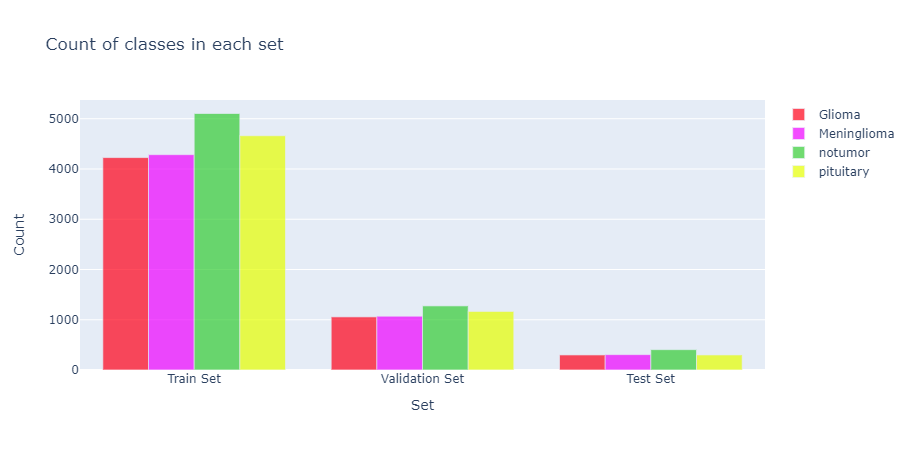

In [5]:
y = dict()
y[0] = []
y[1] = []
y[2] = []
y[3] = []

for set_name in (y_train, y_valid, y_test):
    y[0].append(np.sum(set_name == 0))
    y[1].append(np.sum(set_name == 1))
    y[2].append(np.sum(set_name == 2))
    y[3].append(np.sum(set_name == 3))

trace0 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[0],
    name='Glioma',
    marker=dict(color='#ff0019'),
    opacity=0.7
)
trace1 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[1],
    name='Meningioma',
    marker=dict(color='#ee00ff'),
    opacity=0.7
)
trace2 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[2],
    name='notumor',
    marker=dict(color='#33cc33'),
    opacity=0.7
)
trace3 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[3],
    name='pituitary',
    marker=dict(color='#e5ff00'),
    opacity=0.7
)
data = [trace0, trace1, trace2, trace3]
layout = go.Layout(
    title='Count of classes in each set',
    xaxis={'title': 'Set'},
    yaxis={'title': 'Count'}
)
fig = go.Figure(data, layout)
iplot(fig)

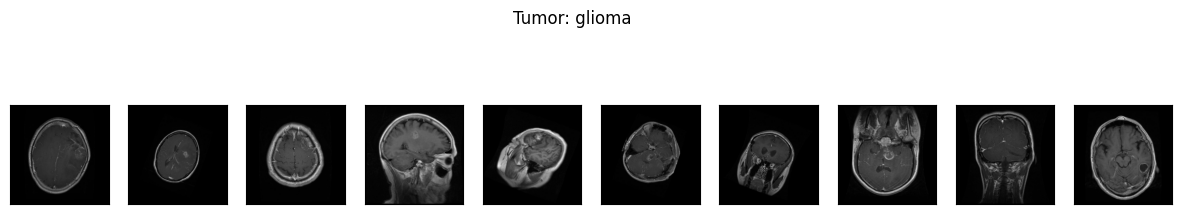

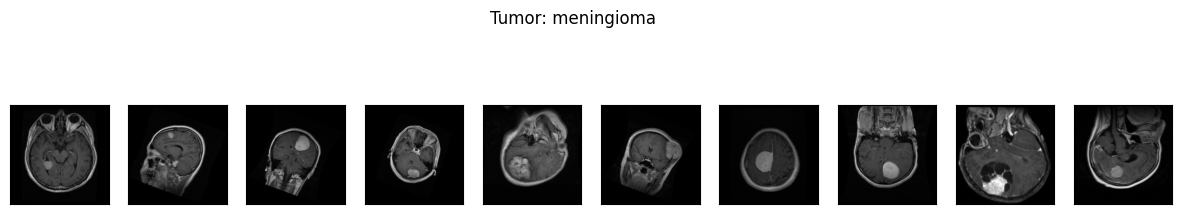

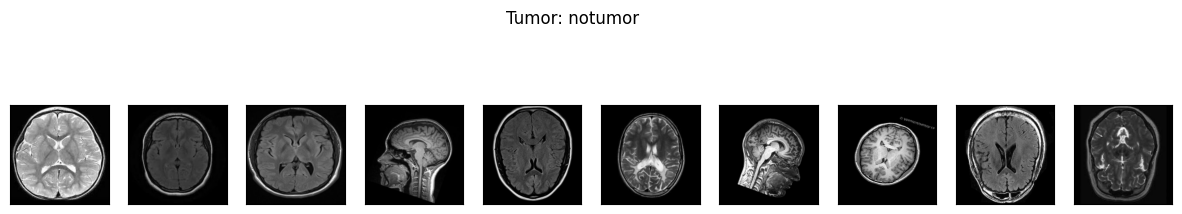

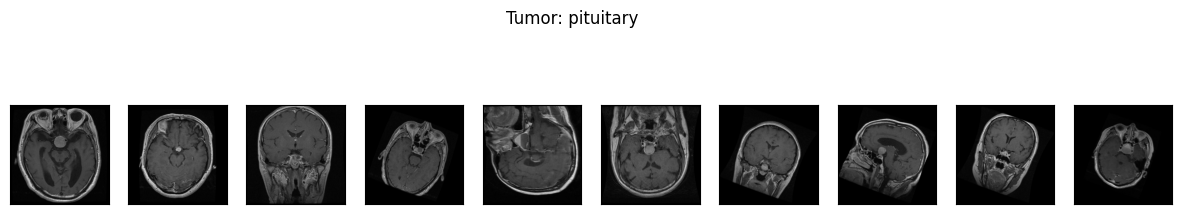

In [6]:
def plot_samples(X, y, labels_dict, n=50):
    """
    Creates a gridplot for desired number of images (n) from the specified set
    """
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(15, 3))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(list(labels.keys())[index]))
        plt.show()

plot_samples(X_train, y_train, labels, 10)

## Crop images

Cropping black areas is beneficial for model training because it allows the model to ignore the black areas of the MRI scan and focus on the important features.

It's mandatory to ensure that after cropping, the image size is the same as the original.

Original Image Shape: (224, 224, 3)
Cropped and Resized Image Shape: (224, 224, 3)


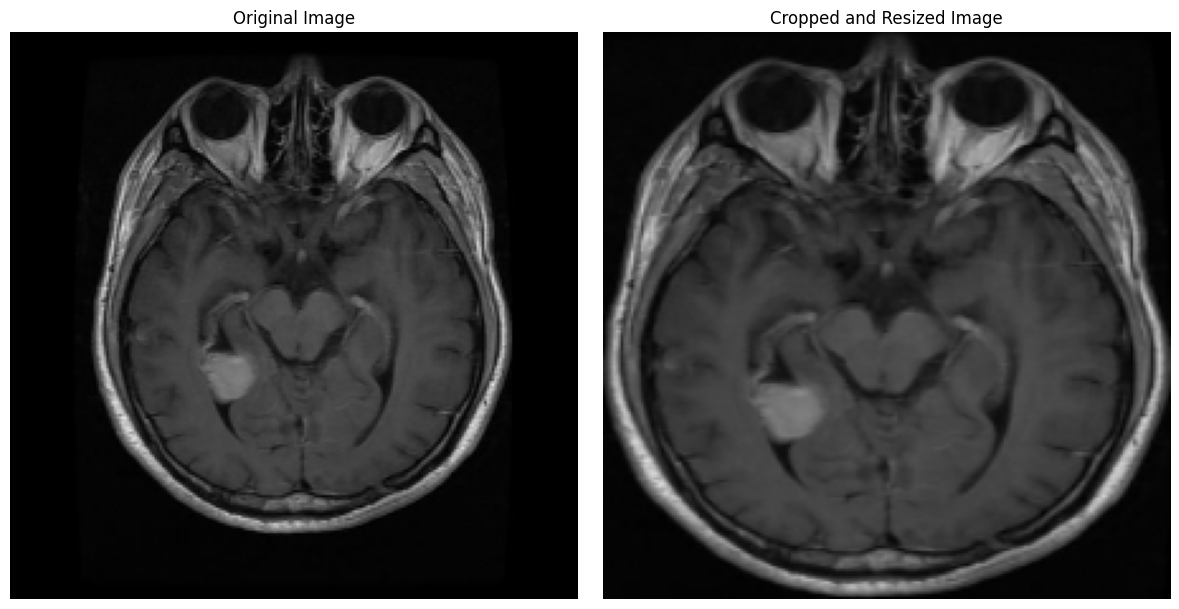

In [7]:
def crop_and_resize(image):
    original_shape = image.shape[:2]  # Save the OG size
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY) # Set threshold for contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnt = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(cnt)
    crop = image[y:y+h, x:x+w]
    resized_crop = cv2.resize(crop, (original_shape[1], original_shape[0]))  # Resize to original dimentions
    return resized_crop

image = X_train[1]

# Original size
original_shape = image.shape
print(f"Original Image Shape: {original_shape}")

cropped_and_resized_image = crop_and_resize(image)

# Cropped size
cropped_and_resized_shape = cropped_and_resized_image.shape
print(f"Cropped and Resized Image Shape: {cropped_and_resized_shape}")

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
cropped_and_resized_image_rgb = cv2.cvtColor(cropped_and_resized_image, cv2.COLOR_BGR2RGB)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(image_rgb)
axes[0].set_title('Original Image')
axes[0].axis('off')
axes[1].imshow(cropped_and_resized_image_rgb)
axes[1].set_title('Cropped and Resized Image')
axes[1].axis('off')

plt.tight_layout()
plt.show()

### Apply cropping to all images

Now apply the function to all images in the train, test, and validation datasets. It's important to note that not every single image will be transformed because contours may not be found. Therefore, we will print the percentage of transformed images as a KPI of the function's performance.

X_train_resized shape: (18278, 224, 224, 3)
X_test_resized shape: (1311, 224, 224, 3)
X_valid_resized shape: (4570, 224, 224, 3)
Percentage of images transformed in X_train: 94.68%
Percentage of images transformed in X_test: 86.88%
Percentage of images transformed in X_valid: 94.64%


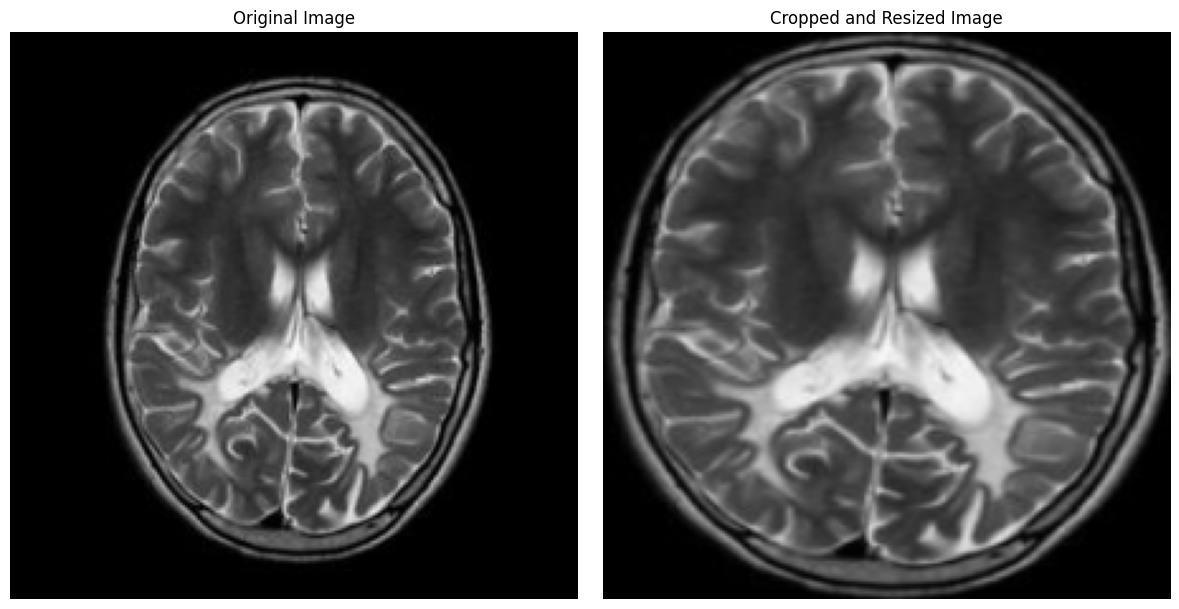

In [8]:
def crop_and_resize(image):
    original_shape = image.shape[:2]  # Save the original size
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)  # Set threshold for contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        cnt = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(cnt)
        crop = image[y:y+h, x:x+w]
        resized_crop = cv2.resize(crop, (original_shape[1], original_shape[0]))  # Resize to original dimensions
        return resized_crop, (w * h) < (original_shape[0] * original_shape[1])
    else:
        return cv2.resize(image, (original_shape[1], original_shape[0])), False  # If no contours found, return resized original image

def apply_transform_and_calculate_percentage(dataset):
    transformed_count = 0
    transformed_dataset = []

    for img in dataset:
        transformed_img, is_transformed = crop_and_resize(img)
        transformed_dataset.append(transformed_img)
        if is_transformed:
            transformed_count += 1

    transformed_percentage = (transformed_count / len(dataset)) * 100
    return np.array(transformed_dataset), transformed_percentage

X_train_resized, train_transformed_percentage = apply_transform_and_calculate_percentage(X_train)
X_test_resized, test_transformed_percentage = apply_transform_and_calculate_percentage(X_test)
X_valid_resized, valid_transformed_percentage = apply_transform_and_calculate_percentage(X_valid)

print(f"X_train_resized shape: {X_train_resized.shape}")
print(f"X_test_resized shape: {X_test_resized.shape}")
print(f"X_valid_resized shape: {X_valid_resized.shape}")

print(f"Percentage of images transformed in X_train: {train_transformed_percentage:.2f}%")
print(f"Percentage of images transformed in X_test: {test_transformed_percentage:.2f}%")
print(f"Percentage of images transformed in X_valid: {valid_transformed_percentage:.2f}%")

image = X_train[20]
cropped_and_resized_image, _ = crop_and_resize(image)

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
cropped_and_resized_image_rgb = cv2.cvtColor(cropped_and_resized_image, cv2.COLOR_BGR2RGB)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(image_rgb)
axes[0].set_title('Original Image')
axes[0].axis('off')
axes[1].imshow(cropped_and_resized_image_rgb)
axes[1].set_title('Cropped and Resized Image')
axes[1].axis('off')

plt.tight_layout()
plt.show()

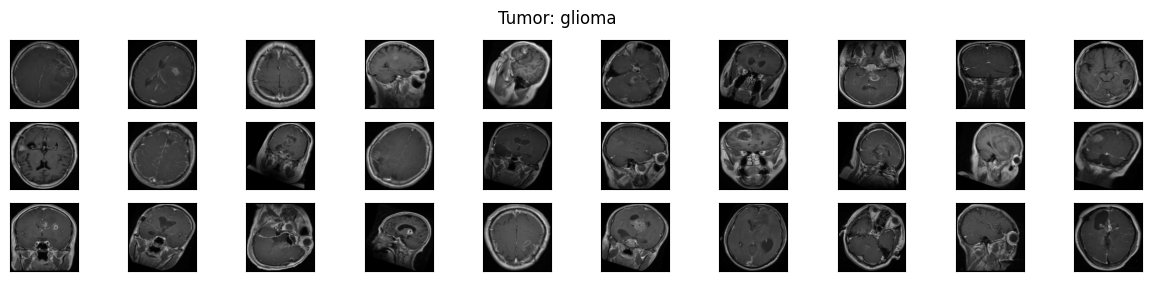

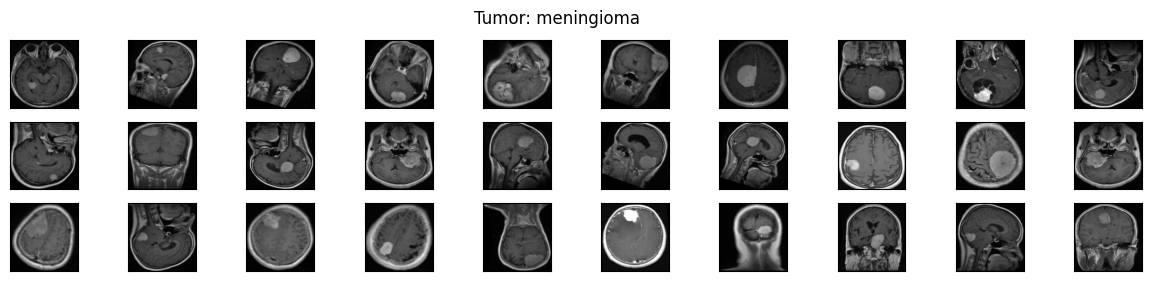

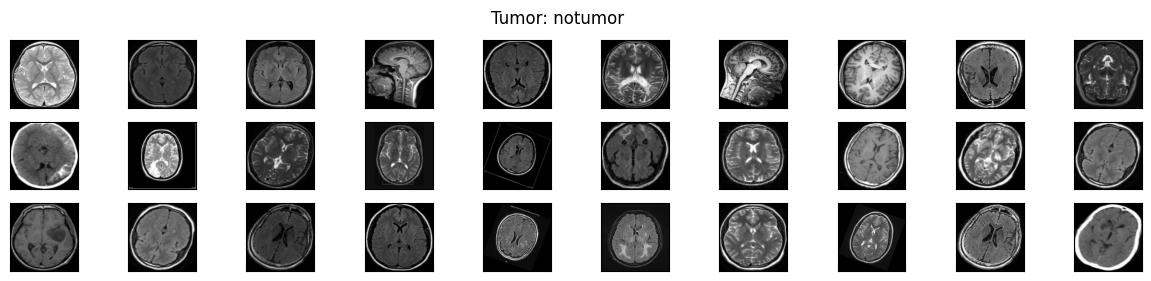

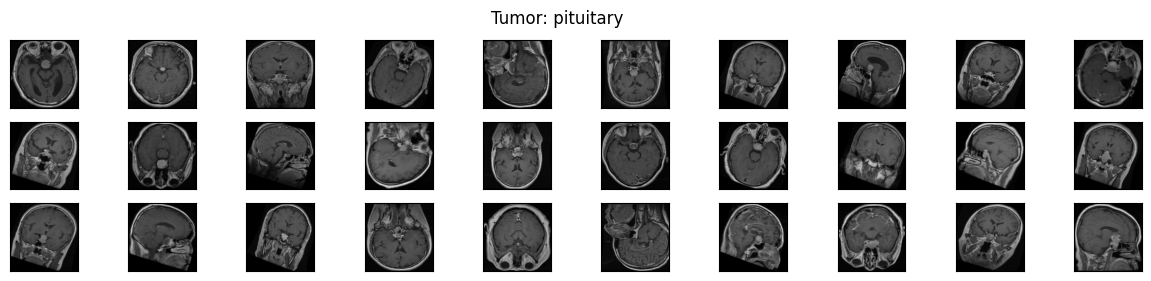

In [9]:
plot_samples(X_train_resized, y_train, labels, 30)

### Save images

Now save the images in a folder for training the DL model

In [10]:
!rm -rf /kaggle/working/VAL_CROP
!rm -rf /kaggle/working/TRAIN_CROP
!rm -rf /kaggle/working/TEST_CROP

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



In [11]:
def save_new_images(x_set, y_set, folder_name):
    i = 0
    for (img, imclass) in zip(x_set, y_set):
        if imclass == 0:
            cv2.imwrite(folder_name+'GL/'+str(i)+'.jpg', img)
        elif imclass == 1:
            cv2.imwrite(folder_name+'MEN/'+str(i)+'.jpg', img)
        elif imclass == 2:
            cv2.imwrite(folder_name+'NO/'+str(i)+'.jpg', img)
        else:
            cv2.imwrite(folder_name+'PIT/'+str(i)+'.jpg', img)
        i += 1

# saving new images to the folder
!mkdir TRAIN_CROP TEST_CROP VAL_CROP TRAIN_CROP/GL TRAIN_CROP/MEN TRAIN_CROP/NO TRAIN_CROP/PIT TEST_CROP/GL TEST_CROP/MEN TEST_CROP/NO TEST_CROP/PIT VAL_CROP/GL VAL_CROP/MEN VAL_CROP/NO VAL_CROP/PIT

save_new_images(X_train_resized, y_train, folder_name='TRAIN_CROP/')
save_new_images(X_valid_resized, y_valid, folder_name='VAL_CROP/')
save_new_images(X_test_resized, y_test, folder_name='TEST_CROP/')

## Augmentations

Now it's time to improve our data with some augmentations, but, What is Augmentations?

Well, Augmentations is a name for transformations and these transformations can include operations such as rotation, scaling, translation, flipping, cropping, color adjustments, and adding noise. By using augmentations, models can become more resilient to variations and distortions in real-world data, leading to better performance and reduced overfitting.

Here is an example of what Augmentations can do in one single image

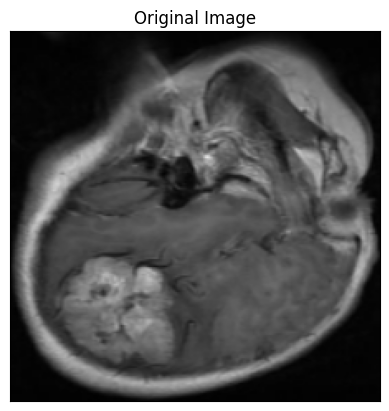

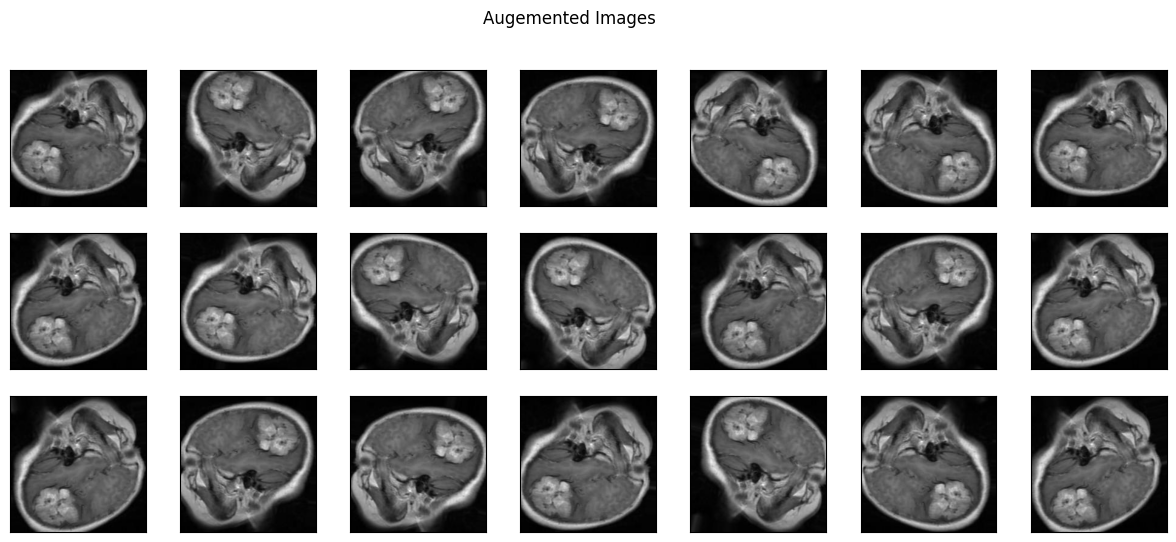

In [12]:
test_augmentations = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    horizontal_flip=True,
    vertical_flip=True
)

!rm -rf /kaggle/working/preview

os.mkdir('preview')
x = X_train_resized[10]  
x = x.reshape((1,) + x.shape) 

i = 0
for batch in test_augmentations.flow(x, batch_size=1, save_to_dir='preview', save_prefix='aug_img', save_format='jpg'):
    i += 1
    if i > 20:
        break 
        
plt.imshow(X_train_resized[10])
plt.xticks([])
plt.yticks([])
plt.title('Original Image')
plt.show()

plt.figure(figsize=(15,6))
i = 1
for img in os.listdir('preview/'):
    img = cv2.imread('preview/' + img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3,7,i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    i += 1
    if i > 3*7:
        break
plt.suptitle('Augemented Images')
plt.show()

### We have 21 images from one!

In [23]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,
    vertical_flip=True
)

train_generator = train_datagen.flow_from_directory(
    'TRAIN_CROP/',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

validation_datagen = ImageDataGenerator(rescale=0.25)

validation_generator = validation_datagen.flow_from_directory(
    'VAL_CROP/',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 18278 images belonging to 4 classes.
Found 4570 images belonging to 4 classes.


In [24]:
def count_images(directory):
    total_images = 0
    for root, dirs, files in os.walk(directory):
        total_images += len([file for file in files if file.endswith(('png', 'jpg', 'jpeg'))])
    return total_images

train_dir = 'TRAIN_CROP/'
val_dir = 'VAL_CROP/'

total_train_images = count_images(train_dir)
total_val_images = count_images(val_dir)

print(f"Total training images: {total_train_images}")
print(f"Total validation images: {total_val_images}")

# Ajustar steps_per_epoch y validation_steps

steps_per_epoch = total_train_images // BATCH_SIZE
validation_steps = total_val_images // BATCH_SIZE

print(f"Steps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")

Total training images: 18278
Total validation images: 4570
Steps per epoch: 571
Validation steps: 142


## Train model - Model

In [17]:
INPUT_SHAPE = IMG_SIZE + (3,)
NUM_CLASSES = 4
RANDOM_SEED = 42


strategy = tf.distribute.MirroredStrategy()

with strategy.scope():

    base_model = VGG16(
        weights="imagenet",
        include_top=False,
        input_shape=INPUT_SHAPE
    )


    for layer in base_model.layers:
        layer.trainable = False

    model = models.Sequential()

    model.add(base_model)


    model.add(layers.Flatten(name="flatten"))
    model.add(layers.Dropout(0.5, name="dropout"))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(NUM_CLASSES, activation='softmax', name="output"))
    
    model.build((None,) + INPUT_SHAPE)
    
    model.compile(
        loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        metrics=['accuracy']
    )

model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,934,596 (68.42 MB)

 Trainable params: 3,219,908 (12.28 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [18]:
epochs = 100
es = EarlyStopping(
    monitor='accuracy',
    mode='max',
    patience=25,
    restore_best_weights=True
)


history = model.fit(
    train_generator,
    epochs=epochs, 
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps = validation_steps,
    callbacks=[es]
)

score = model.evaluate(validation_generator, verbose=0)
print(f'Validation loss: {score[0]}')
print(f'Validation accuracy: {score[1]}')

Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



285/285 ━━━━━━━━━━━━━━━━━━━━ 118s 375ms/step - accuracy: 0.5384 - loss: 2.7562 - val_accuracy: 0.7905 - val_loss: 0.6587
Epoch 2/100
285/285 ━━━━━━━━━━━━━━━━━━━━ 103s 362ms/step - accuracy: 0.7511 - loss: 0.7524 - val_accuracy: 0.8662 - val_loss: 0.5410
Epoch 3/100
  2/285 ━━━━━━━━━━━━━━━━━━━━ 23s 83ms/step - accuracy: 0.8203 - loss: 0.3910 

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning:

Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.



285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8126 - loss: 0.3838 - val_accuracy: 0.8462 - val_loss: 0.5351
Epoch 4/100
285/285 ━━━━━━━━━━━━━━━━━━━━ 109s 372ms/step - accuracy: 0.7982 - loss: 0.5923 - val_accuracy: 0.8847 - val_loss: 0.5224
Epoch 5/100
285/285 ━━━━━━━━━━━━━━━━━━━━ 104s 364ms/step - accuracy: 0.8248 - loss: 0.5072 - val_accuracy: 0.9014 - val_loss: 0.5212
Epoch 6/100
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9056 - loss: 0.3635 - val_accuracy: 1.0000 - val_loss: 0.3062
Epoch 7/100
285/285 ━━━━━━━━━━━━━━━━━━━━ 109s 374ms/step - accuracy: 0.8503 - loss: 0.4265 - val_accuracy: 0.8970 - val_loss: 0.4857
Epoch 8/100
285/285 ━━━━━━━━━━━━━━━━━━━━ 103s 362ms/step - accuracy: 0.8589 - loss: 0.3832 - val_accuracy: 0.9181 - val_loss: 0.4844
Epoch 9/100
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step - accuracy: 0.8125 - loss: 0.3954 - val_accuracy: 1.0000 - val_loss: 0.4162
Epoch 10/100
285/285 ━━━━━━━━━━━━━━━━━━━━ 109s 373ms/step - accuracy: 0.8767 - loss: 0.3373

### Performance Plots

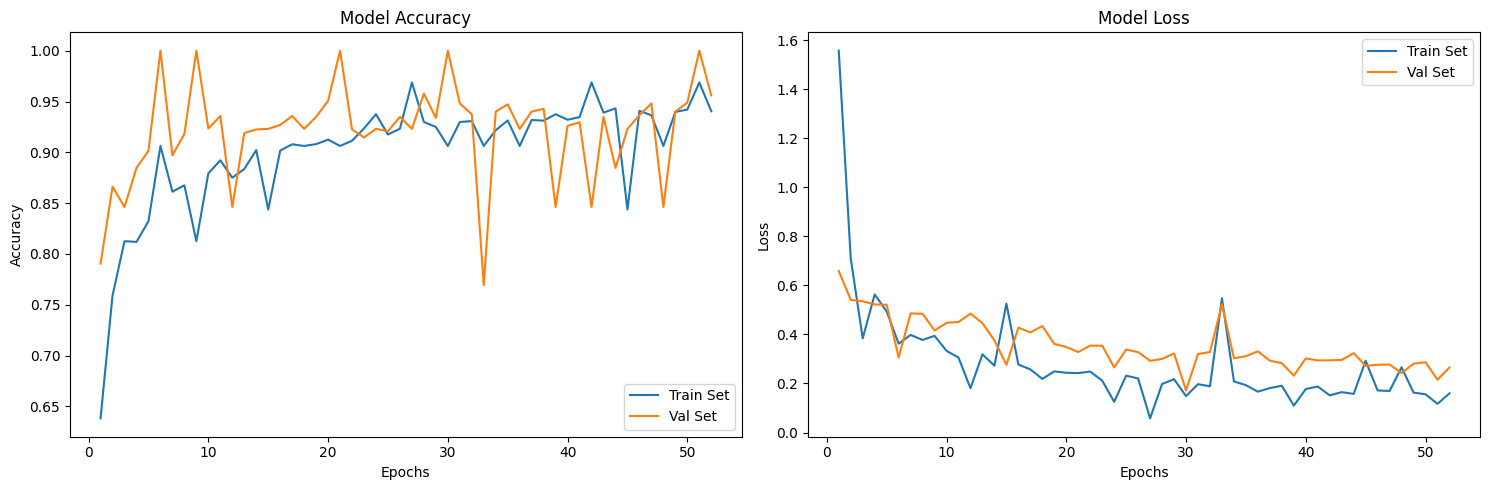

In [19]:
# plot model performance
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

### Test on unseen data

In [21]:
test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_directory(
    'TEST_CROP/', 
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_score = model.evaluate(test_generator, verbose=0)
print(f'Test loss: {test_score[0]}')
print(f'Test accuracy: {test_score[1]}')

Found 1311 images belonging to 4 classes.
Test loss: 0.20609383285045624
Test accuracy: 0.9359756112098694


### Confussion Matrix on unseen data

21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 175ms/step


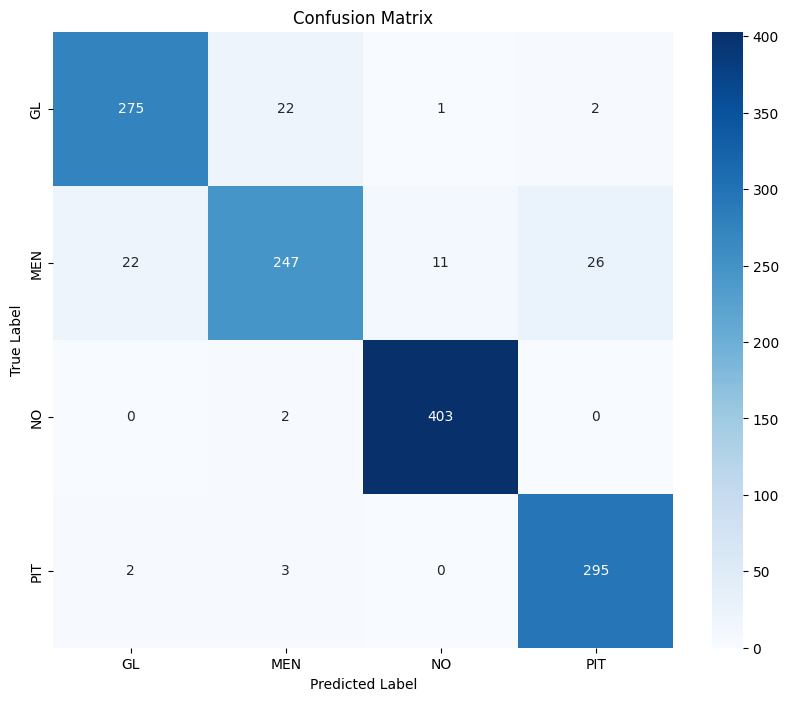

In [22]:
# Predictions and true values
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes

# Confussion matrix
cm = confusion_matrix(y_true, y_pred)
class_names = list(test_generator.class_indices.keys())
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

## Results

The model executed a early stop in 52th epoch, reaching a 93.6% of accuracy on unseen data (test_dataset).

The confusion matrix suggests possible improvements in the meningioma classification, so a good idea is to get more information for this specific category, perform transformations, change the image size, or change the model architecture, experiment with different activation functions, learning rates, optimizers and loss functions.